In [1]:
# %%
%load_ext autoreload
%autoreload 2

In [2]:
# %% imports
import pandas as pd
import numpy as np
from scripts.signals import Signal, MeanReversion, CrossSectionCorrelation, BetaResidual
from scripts.filters import VolumeFilter, FixedVolumeFilter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# %% loading data
raw_data = pd.read_csv('../data/data_f2009.csv', parse_dates=['date']).set_index(['date', 'ticker'])
data = raw_data.sort_index()

KeyboardInterrupt: 

In [ ]:
datasample = data.loc[:"2013-12-17"]

In [ ]:
datasample.head()

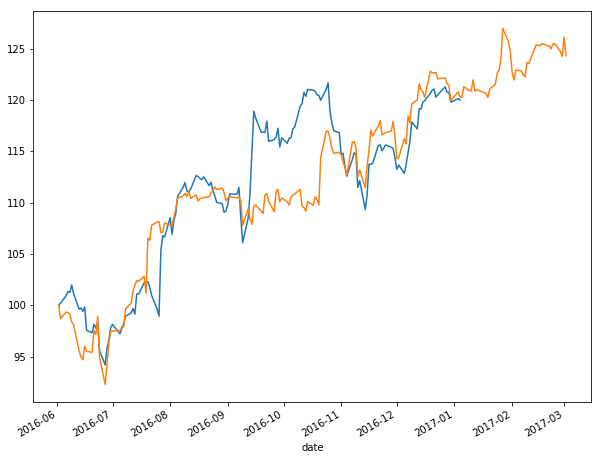

In [72]:
plt.figure(figsize=(10, 8))
a = data.loc(axis=0)[:, "AAPL"].adj_close.loc["2016-06-02":"2017-01-04"]
a.index = a.index.droplevel(1)
a *= 1 / a.iloc[0] * 100
a.plot()

b = data.loc(axis=0)[:, "MSFT"].adj_close.loc["2016-06-02":"2017-03-02"]
b.index = b.index.droplevel(1)
b *= 1 / b.iloc[0] * 100
b.plot()

In [109]:
returns_a = np.diff(np.log(a.values[:100]))
returns_b = np.diff(np.log(b.values[:100]))

In [163]:
r = np.corrcoef(returns_a, returns_b)[0, 1]
r = .6
sigma1 = np.var(returns_a)
sigma2 = np.var(returns_b)

In [164]:
def conditional_distribution(mu1, mu2, sigma1, sigma2, r, a):
    if sigma2 == 0:
        return mu1, 0.
    return mu1 + r * np.sqrt(sigma1 / sigma2) * (a - mu2), (1 - r**2) * sigma1

In [165]:
close_reference = a.values[:100]
close_target = b.values[:100]

In [175]:
n_days = 40

In [176]:
d0 = 0
initial_price_reference = close_reference[d0]
initial_price_target = close_target[d0]

conditional_new_prices = []
conditional_new_price_ups = []
conditional_new_price_downs = []
conditional_new_price_ups2 = []
conditional_new_price_downs2 = []

for d in range(0, n_days):
    new_price = close_reference[d0 + d]
    log_return = np.log(new_price / initial_price_reference)
    conditional_mu, conditional_sigma2 = conditional_distribution(0., 0., 
                                                                  d * sigma1, d * sigma2, 
                                                                  r, 
                                                                  log_return)
    conditional_new_price = initial_price_target * np.exp(conditional_mu)
    conditional_new_price_up = initial_price_target * np.exp(conditional_mu + .5 * np.sqrt(conditional_sigma2))
    conditional_new_price_up2 = initial_price_target * np.exp(conditional_mu + np.sqrt(conditional_sigma2))
    conditional_new_price_down = initial_price_target * np.exp(conditional_mu - .5 * np.sqrt(conditional_sigma2))
    conditional_new_price_down2 = initial_price_target * np.exp(conditional_mu - np.sqrt(conditional_sigma2))

    conditional_new_prices.append(conditional_new_price)
    conditional_new_price_ups.append(conditional_new_price_up)
    conditional_new_price_downs.append(conditional_new_price_down)
    conditional_new_price_ups2.append(conditional_new_price_up2)
    conditional_new_price_downs2.append(conditional_new_price_down2)

DatetimeIndex(['2016-06-02', '2016-06-03', '2016-06-06', '2016-06-07',
               '2016-06-08', '2016-06-09', '2016-06-10', '2016-06-13',
               '2016-06-14', '2016-06-15', '2016-06-16', '2016-06-17',
               '2016-06-20', '2016-06-21', '2016-06-22', '2016-06-23',
               '2016-06-24', '2016-06-27', '2016-06-28', '2016-06-29',
               '2016-06-30', '2016-07-01', '2016-07-05', '2016-07-06',
               '2016-07-07', '2016-07-08', '2016-07-11', '2016-07-12',
               '2016-07-13', '2016-07-14', '2016-07-15', '2016-07-18',
               '2016-07-19', '2016-07-20', '2016-07-21', '2016-07-22',
               '2016-07-25', '2016-07-26', '2016-07-27', '2016-07-28'],
              dtype='datetime64[ns]', name='date', freq=None)

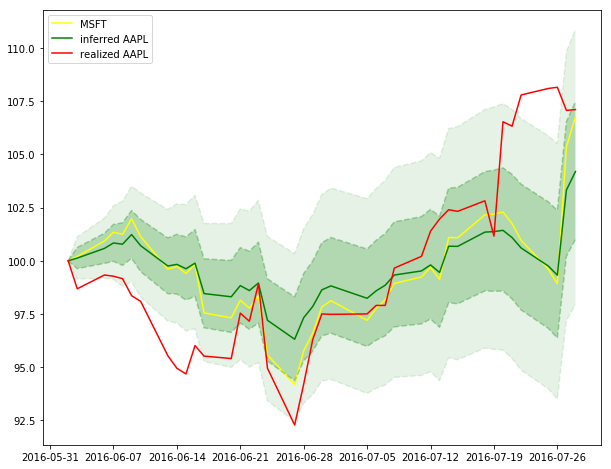

In [374]:
plt.figure(figsize=(10, 8))
plt.plot(a.index[:n_days], close_reference[:n_days], 'yellow', label='MSFT')

plt.plot(a.index[:n_days], conditional_new_prices, 'g-', label='inferred AAPL')

plt.fill_between(a.index[:n_days], 
                 conditional_new_prices, 
                 conditional_new_price_ups, 
                 facecolor='green', interpolate=True, alpha = .3)
plt.fill_between(a.index[:n_days], 
                 conditional_new_price_ups, 
                 conditional_new_price_ups2, 
                 facecolor='green', interpolate=True, alpha = .1)
plt.plot(a.index[:n_days], conditional_new_price_ups, 'g--', alpha = .3)
plt.plot(a.index[:n_days], conditional_new_price_ups2, 'g--', alpha = .1)

plt.fill_between(a.index[:n_days], 
                 conditional_new_prices, 
                 conditional_new_price_downs, 
                 facecolor='green', interpolate=True, alpha = .3)
plt.fill_between(a.index[:n_days], 
                 conditional_new_price_downs, 
                 conditional_new_price_downs2, 
                 facecolor='green', interpolate=True, alpha = .1)
plt.plot(a.index[:n_days], conditional_new_price_downs, 'g--', alpha = .3)
plt.plot(a.index[:n_days], conditional_new_price_downs2, 'g--', alpha = .1)

plt.plot(a.index[:n_days], close_target[:n_days], 'r', label="realized AAPL")
plt.legend()
lim = plt.ylim()

In [204]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


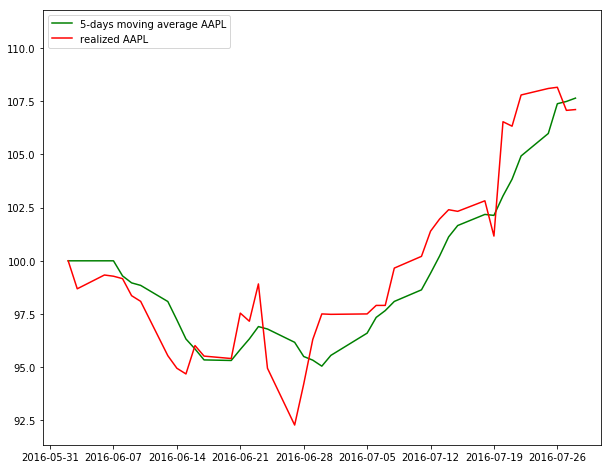

In [233]:
n_ma = 5
plt.figure(figsize=(10, 8))

plt.plot(a.index[:n_days], np.concatenate([[100] * (n_ma - 1), moving_average(close_target[:n_days], n_ma)]), 'g-', 
         label='5-days moving average AAPL')


plt.plot(a.index[:n_days], close_target[:n_days], 'r', label="realized AAPL")

#plt.plot(a.index[:n_days][n_ma-1:],
#        100 + close_target[:n_days][n_ma-1:] - moving_average(close_target[:n_days], n_ma))
plt.ylim(lim)
plt.legend(loc=2)

### Correlations

In [34]:
data_2017 = raw_data_residuals.loc(axis=0)["2017-01-05":, :]

In [35]:
nb_stocks = 500
data_2017["filter"] = FixedVolumeFilter(data_2017, nb_stocks, "2017-01-05").get_filter()

/Users/marc/.miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/marc/Documents/Stanford/Class/3rdQuarter/MS&E448/algotrading/scripts/filters/fixed_volume_fltr.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data["filter"][past_data < 0.98 * self.n_past] = 0
/Users/marc/Documents/Stanford/Class/3rdQuarter/MS&E448/algotrading/scripts/filters/fixed_volume_fltr.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [53]:
tickers = data_2017["filter"].loc["2018-01-05", :].sort_values()[-200:].index.get_level_values(1)

In [4]:
raw_data_residuals = pd.read_csv("../data/data_f2009_withbeta.csv", parse_dates=["date"]).set_index(["date", "ticker"])

In [5]:
raw_data_residuals["past_perf_res"] = raw_data_residuals.past_perf_1d - \
                raw_data_residuals.beta_market * raw_data_residuals.spy_past_perf

In [18]:
import seaborn as sns

In [22]:
t = raw_data_residuals.index.get_level_values(1).unique()
random_tickers = np.random.choice(t, size=50, replace=False)

In [23]:
# tickers = ["AAPL", "MSFT", "F", "GM", "XOM", "CVX"]
tickers = random_tickers

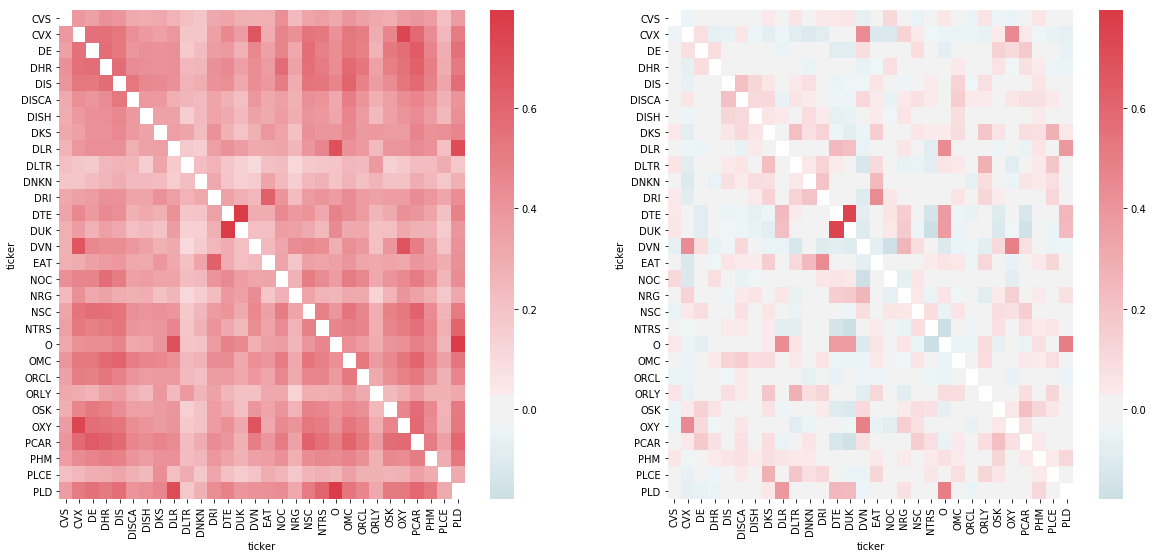

In [84]:
corr1 = raw_data_residuals.loc(axis=0)[:, tick_small].future_perf_1d.unstack(1).corr()
corr2 = raw_data_residuals.loc(axis=0)[:, tick_small].past_perf_res.unstack(1).corr()
corr1 += np.diag([np.nan] * len(tick_small))
corr2 += np.diag([np.nan] * len(tick_small))
vmax = max(np.max(np.max(corr1 - np.eye(len(tick_small)))), np.max(np.max(corr2 - np.eye(len(tick_small)))))
vmin = min(np.min(np.min(corr1 - np.eye(len(tick_small)))), np.min(np.min(corr2 - np.eye(len(tick_small)))))

plt.subplots(figsize=(20, 9))
plt.subplot(121)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1, cmap=cmap, vmax=vmax, center=0., vmin=vmin)

plt.subplot(122)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr2, cmap=cmap, vmax=vmax, center=0., vmin=vmin)

In [80]:
corr1 = raw_data_residuals.loc(axis=0)[:, tickers].future_perf_1d.unstack(1).corr()
corr2 = raw_data_residuals.loc(axis=0)[:, tickers].past_perf_res.unstack(1).corr()

In [27]:
corr1[np.isnan(corr1)] = 0.
corr2[np.isnan(corr2)] = 0.

In [74]:
np.linalg.cond(corr1)

3782.694545231814

In [56]:
np.linalg.cond(corr2)

341.99614213692143

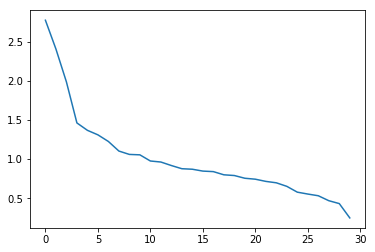

In [91]:
corr1 = raw_data_residuals.loc(axis=0)[:, tick_small].past_perf_res.unstack(1).corr()
ev = np.linalg.eigvals(corr1)
plt.plot(sorted(ev, reverse=True))

In [92]:
for v in sorted(ev, reverse=True):
    print(v, ev[0] / v)

2.771537568909966 1.0
2.404870071877918 1.1524687347228386
1.9852036310143568 1.3960973703709303
1.4614275581685858 1.8964590844195988
1.3670350635178614 2.0274078133576374
1.3093639018261112 2.116705344514712
1.2247476075656216 2.26294589333294
1.1025019613957143 2.5138618033852143
1.059577679628737 2.6157002192430845
1.0542445412731198 2.628932340084038
0.9756323824861892 2.8407601250865606
0.9624859992859509 2.8795614387805273
0.9177895493642495 3.019796391046077
0.8771334389177144 3.1597673124054384
0.8705415726952669 3.1836935257773646
0.8468070945602961 3.2729267228790575
0.8401451238161164 3.298879551095956
0.7995163488276285 3.4665176928201817
0.7902806476777705 3.507029530653564
0.7555057832468984 3.668453148033985
0.7434683158067699 3.72784893449353
0.7155295139714662 3.873407755784745
0.6973943987866419 3.974132246734433
0.6522914036256473 4.248925485610973
0.5780790456384696 4.794392029638253
0.5539233080538206 5.003468040815275
0.5322704815330288 5.20700971605164
0.4691546

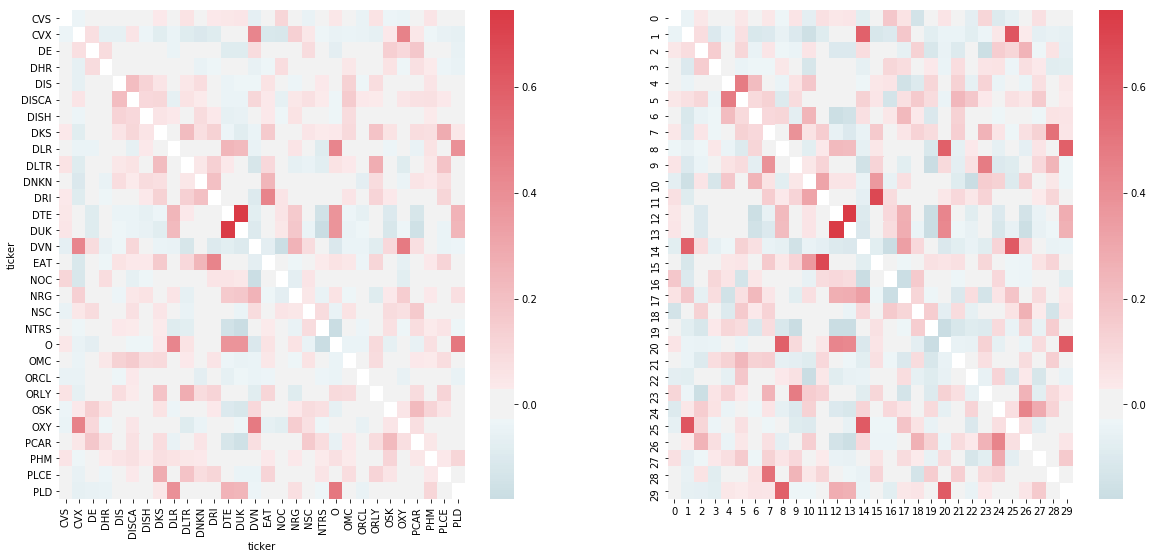

In [93]:
tick_small = tickers[:30]

corr1 = raw_data_residuals.loc(axis=0)[:, tick_small].past_perf_res.unstack(1).corr()
corr2 = np.linalg.pinv(np.linalg.pinv(corr1, rcond=.3))

corr1 += np.diag([np.nan] * len(tick_small))
corr2 += np.diag([np.nan] * len(tick_small))
vmax = max(np.max(np.max(corr1 - np.eye(len(tick_small)))), np.max(np.max(corr2 - np.eye(len(tick_small)))))
vmin = min(np.min(np.min(corr1 - np.eye(len(tick_small)))), np.min(np.min(corr2 - np.eye(len(tick_small)))))

plt.subplots(figsize=(20, 9))
plt.subplot(121)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1, cmap=cmap, vmax=vmax, center=0., vmin=vmin)

plt.subplot(122)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr2, cmap=cmap, vmax=vmax, center=0., vmin=vmin)

### Beta residuals

In [86]:
aapl_df

,,index,adj_volume,adj_close,future_perf_1d,past_perf_1d,spy_past_perf,beta_market,past_perf_res
date,ticker,,,,,,,,
2009-01-05,AAPL,5,295402100.0,12.154848,-0.016494,0.042204,-0.001183,NaN,NaN
2009-01-06,AAPL,2550,322327600.0,11.954366,-0.021608,-0.016494,0.006677,NaN,NaN
2009-01-07,AAPL,5096,188262200.0,11.696053,0.018569,-0.021608,-0.029956,NaN,NaN
2009-01-08,AAPL,7642,168375200.0,11.913242,-0.022869,0.018569,0.004103,NaN,NaN
2009-01-09,AAPL,10188,136711400.0,11.640792,-0.021197,-0.022869,-0.021441,NaN,NaN
2009-01-12,AAPL,12734,154429100.0,11.394046,-0.010715,-0.021197,-0.024021,NaN,NaN
2009-01-13,AAPL,15280,199599400.0,11.271957,-0.027135,-0.010715,0.001840,NaN,NaN
2009-01-14,AAPL,17826,255416000.0,10.966094,-0.022852,-0.027135,-0.031454,NaN,NaN
2009-01-15,AAPL,20371,457908500.0,10.715492,-0.012593,-0.022852,0.000356,NaN,NaN


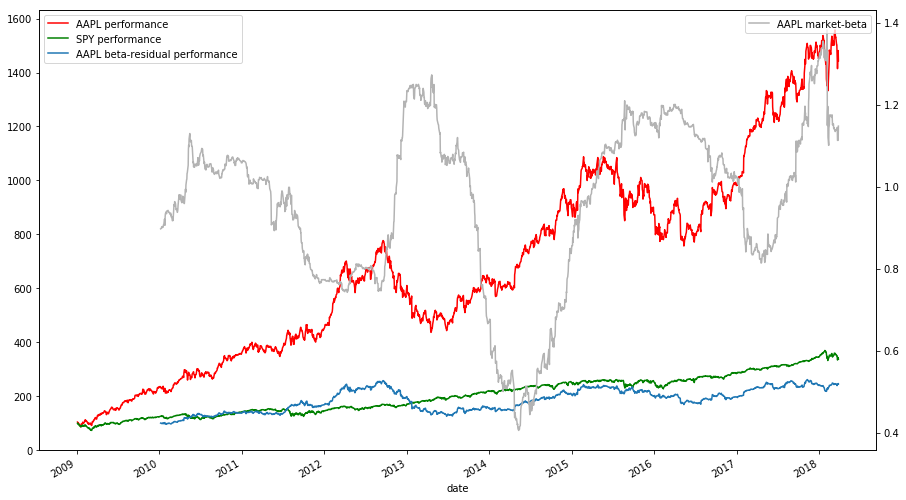

In [91]:
aapl_df = raw_data_residuals.loc(axis=0)[:, "AAPL"]
plt.figure(figsize=(15, 9))
(100 * (aapl_df.past_perf_1d + 1.).cumprod().reset_index(level=1, 
                                                         drop=True)).plot(label="AAPL performance", color="r")
(100 * (aapl_df.spy_past_perf + 1.).cumprod().reset_index(level=1, 
                                                          drop=True)).plot(label="SPY performance", color="g")
(100 * (aapl_df.past_perf_res + 1.).cumprod().reset_index(level=1, 
                                                          drop=True)).plot(label="AAPL beta-residual performance")
plt.legend()
plt.twinx()
aapl_df.beta_market.reset_index(level=1, drop=True).plot(label="AAPL market-beta", color=".7")


plt.legend(loc=1)
plt.show()

In [113]:
corr1 = raw_data_residuals.loc(axis=0)[:, tickers].future_perf_1d.unstack(1).corr()

In [ ]:
corr2 = raw_data_residuals.loc(axis=0)[:, tickers].past_perf_res.unstack(1).corr()

In [117]:
(corr1 - np.eye(corr1.shape[0])).mean().mean() * 30 / 29

0.24492483664725107

In [118]:
(corr2 - np.eye(corr2.shape[0])).mean().mean() * 30 / 29

0.05299330462366537

In [129]:
corr1 = raw_data_residuals.loc(axis=0)[:, tickers].future_perf_1d.unstack(1).corr()
corr2 = raw_data_residuals.loc(axis=0)[:, tickers].past_perf_res.unstack(1).corr()
corr1 += np.diag([np.nan] * len(tickers))
corr2 += np.diag([np.nan] * len(tickers))
vmax = max(np.max(np.max(corr1 - np.eye(len(tickers)))), np.max(np.max(corr2 - np.eye(len(tickers)))))
vmin = min(np.min(np.min(corr1 - np.eye(len(tickers)))), np.min(np.min(corr2 - np.eye(len(tickers)))))

In [126]:
corr2.mean().mean()

0.05299330462366537

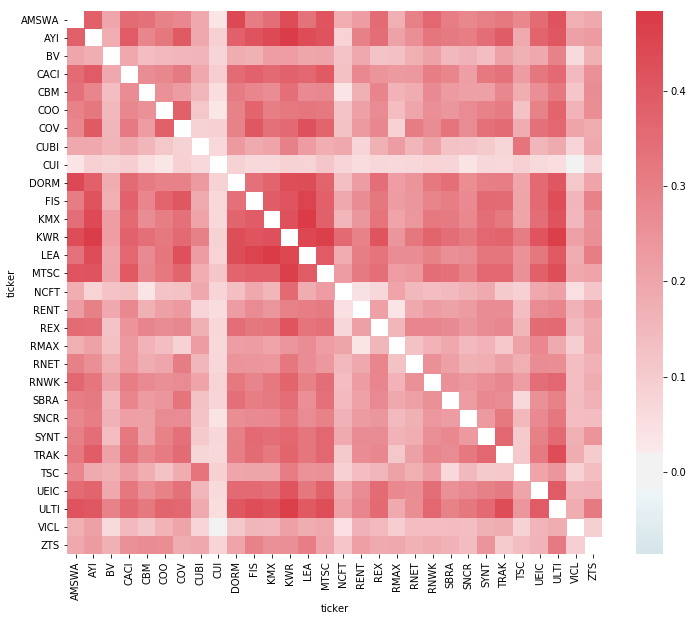

In [130]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1, cmap=cmap, vmax=vmax, center=0., vmin=vmin)

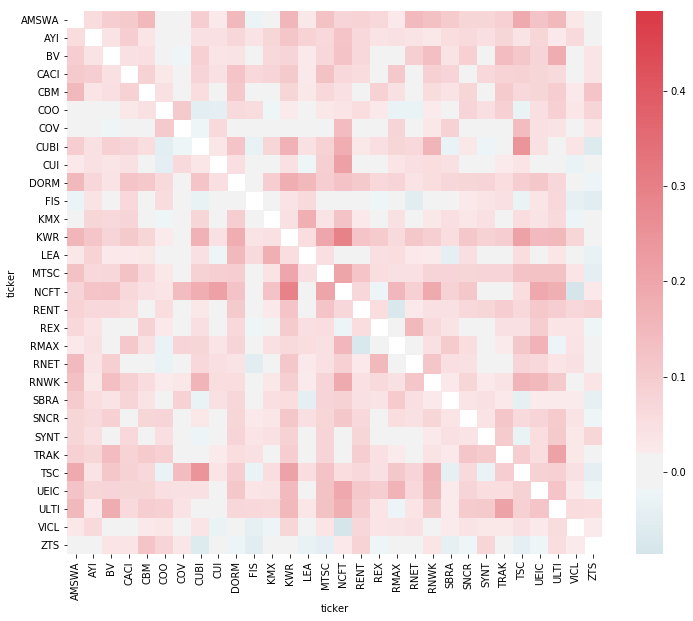

In [132]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr2, cmap=cmap, vmax=vmax, center=0., vmin=vmin)

In [134]:
from scipy.stats import norm

In [140]:
norm.cdf(1.) - norm.cdf(-1.)

0.6826894921370859